In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sl3

#Load Data From Database

In [2]:
dbfile = "../recipes.db"
conn = sl3.connect(dbfile)
cur = conn.cursor()

In [3]:
# Read in 'ingredients' table
query = "SELECT new_description, recipe_id FROM new_ingredients"
all_ingr_df = pd.read_sql(query, conn)

#Calculate Distance Matrix
Construct a matrix of jaccard similarity between each unique ingredient. The similarity is based on the similarities/differences of the list of recipes containing each ingredient (i.e. the more recipes that share two ingredients, and the fewer recipes unique to only one of the two, the higher the jaccard similarity between the them). 

This matrix will be input to our clustering algorithm.

In [4]:
# for each unique ingredient, generate a list of recipes containing that ingredient
recipes_list = list()
for ingredient in all_ingr_df['new_description'].unique():
    recipes_list.append(all_ingr_df[all_ingr_df['new_description']==ingredient])


In [5]:
def get_jaccard_similarity(list1, list2):
    """Calculates jaccard distance between two recipe lists
    this serves as a score of how associated two ingredients are;
    how many recipies are they an ingredient of in common or in contrast
    input: 2 lists of recipe_id's for recipes containing each of two ingredients
    output: a float score of jaccard distance"""
    if len(list1) > len(list2):
        temp = list1
        list1 = list2
        list2 = temp
    
    in_both_count = 0
    
    # loop over every entry in the shorter list and count how
    # many of the recipes are shared between the two
    for recipe_id in list1.recipe_id:
        if len(list2[list2['recipe_id']==recipe_id]) > 0:
            in_both_count += 1
        
    jaccard_similarity = 1.0*in_both_count / (len(list1) + len(list2) - in_both_count)
    #jaccard_distance = 1.0-jaccard_similarity
    
    return jaccard_similarity
        

In [6]:
#construct the similarity matrix

similarity_matrix = [[0 for x in range(len(recipes_list))] for x in range(len(recipes_list))]

# loop over every combination of 2 ingredients and calculate
# the jaccard_distance between their recipe_lists
for i in range(len(recipes_list)):
    for j in range(i+1,len(recipes_list)):
        jaccard_similarity = get_jaccard_similarity(recipes_list[i],recipes_list[j])
        similarity_matrix[i][j] = jaccard_similarity
        similarity_matrix[j][i] = jaccard_similarity


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

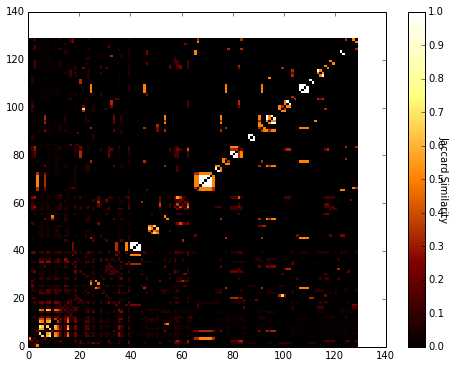

In [42]:
array = np.array(similarity_matrix)

#create heatmap
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = ax.pcolor(array,cmap='afmhot')

#legend
cbar = plt.colorbar(heatmap)
cbar.set_label('Jaccard Similarity', rotation=270)

# Do clustering based on jaccard similarity

In [25]:
from sklearn.cluster import AffinityPropagation

In [26]:
af = AffinityPropagation(affinity='precomputed')
af.fit(similarity_matrix)

AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

In [27]:
labels = af.labels_
labels_unique = np.unique(labels)
n_clusters = len(labels_unique)
print n_clusters, 'Estimated clusters'

for i in range(len(labels_unique)):
    print 'Cluster %d - count:%d - ingredients:'%(i,len(labels[labels==i]))
    for index in np.where(labels==i)[0]:
        print '   %s'%all_ingr_df['new_description'].unique()[index]

25 Estimated clusters
Cluster 0 - count:6 - ingredients:
   cheddar cheese
   bread
   rosemary
   onion
   ranch
   honey
Cluster 1 - count:25 - ingredients:
   garbonzo beans
   olive oil
   lemon juice
   garlic
   salt
   cumin
   paprika
   tahini
   water
   basil
   parsley
   manzanilla olives
   black pepper
   white beans
   red onion
   baking soda
   zucchini
   beets
   eggplant
   egg
   arugula
   wasabi
   chipotle pepper
   hard-boiled egg
   sage
Cluster 2 - count:3 - ingredients:
   green olives
   black beans
   yogurt
Cluster 3 - count:3 - ingredients:
   portabello mushroom
   cream cheese
   serrano peppers
Cluster 4 - count:5 - ingredients:
   cayenne pepper
   cilantro
   jalapeno
   banana peppers
   orange juice
Cluster 5 - count:7 - ingredients:
   pumpkin
   balsamic vinegar
   cottage cheese
   flatbread
   brown sugar
   apple sauce
   bacon
Cluster 6 - count:4 - ingredients:
   sweet potato
   lemon zest
   white pepper
   coriander
Cluster 7 - count:3 -

# Thoughs on similarity cluster results:

The association clusters are interesting. I can see by eye how several of the clusters make sense. And, importantly, I think these cluster choices seem orthogonal to the previous count clustering. I think it will be useful to crosscheck/cross-cut on the 2 clustering labels. For example, cut out all count_cluster = 0 ingredients and see what is left in the similarity clusters. Or alternately, apply the cut before clustering on similarity and see how the results change.

#Comparing count_cluster and similarity_cluster:

In [28]:
# First get the full data_frame including count_cluster
query = "SELECT new_description, mean_proportion, stddev_proportion, counts, norm_counts, count_cluster FROM base_ingredients"
ingr_df = pd.read_sql(query, conn)

ingr_df.set_index(['new_description'],inplace=True)

# Take a look at the data:
print len(ingr_df), 'entries'
print ingr_df.sort(['counts'],ascending=[0]).head(20)

129 entries
                 mean_proportion  stddev_proportion  counts  norm_counts  \
new_description                                                            
garlic                  0.010577           0.007612      82     1.000000   
garbonzo beans          0.598739           0.186017      76     0.926829   
olive oil               0.043827           0.046208      69     0.841463   
lemon juice             0.076270           0.056109      67     0.817073   
salt                    0.004098           0.003616      58     0.707317   
tahini                  0.082664           0.065108      49     0.597561   
cumin                   0.003360           0.003073      37     0.451220   
black pepper            0.001551           0.002348      28     0.341463   
water                   0.138366           0.181471      22     0.268293   
paprika                 0.001801           0.001171      17     0.207317   
cayenne pepper          0.002782           0.003351      16     0.195122   


In [29]:
# now compose a compatible list of similarity_cluster and add it to the dataframe
similar_df = pd.DataFrame({'similarity_cluster':labels},index=all_ingr_df['new_description'].unique())

# Take a look at the data:
print len(similar_df), 'entries'
print similar_df.head(20)

129 entries
                similarity_cluster
cheddar cheese                   0
hummus                           9
bread                            0
apples                          10
garbonzo beans                   1
olive oil                        1
peanut butter                   16
lemon juice                      1
garlic                           1
tofu                             7
salt                             1
cumin                            1
paprika                          1
green olives                     2
cayenne pepper                   4
tahini                           1
black beans                      2
pumpkin                          5
water                            1
curry powder                    15

[20 rows x 1 columns]


In [30]:
# merge the new column into the old dataframe to get the merged df that will be uploaded
merged_df = pd.concat([ingr_df, similar_df], axis=1)
merged_df.head(20)

,mean_proportion,stddev_proportion,counts,norm_counts,count_cluster,similarity_cluster
Italian dressing,0.100105,0.082766,4,0.048780,0,8
allspice,0.000554,0.000400,2,0.024390,0,24
apple sauce,0.089539,NaN,1,0.012195,0,5
apples,0.215378,0.170833,2,0.024390,0,10
artichoke hearts,0.256446,0.051010,3,0.036585,0,17
arugula,0.011392,NaN,1,0.012195,0,1
avocado,0.189037,0.039988,3,0.036585,0,18
bacon,0.049095,NaN,1,0.012195,0,5
baking soda,0.001161,NaN,1,0.012195,0,1
balsamic vinegar,0.026339,0.026988,3,0.036585,0,5


Now we can start looking at some different cuts between the two cluster methods

In [31]:
# print only ingredients for count_cluster!=0
print merged_df[['count_cluster','similarity_cluster']][merged_df['count_cluster']!=0].sort(['similarity_cluster'])

                count_cluster  similarity_cluster
onion                       1                   0
basil                       1                   1
salt                        4                   1
parsley                     1                   1
paprika                     1                   1
olive oil                   3                   1
lemon juice                 3                   1
tahini                      8                   1
water                       5                   1
garlic                      2                   1
garbonzo beans              2                   1
cumin                       7                   1
black pepper                6                   1
cayenne pepper              1                   4
jalapeno                    1                   4
bell pepper                 1                   8
hummus                      1                   9

[17 rows x 2 columns]


# Thoughts
This is already interesting. I think one could use the criteria (count_cluster!=0 && similarity_cluster==1) to chose the ingredients nicely. I want to now calculate and cluster the jaccard distance (dissimilarity) to see if any of the selections according to this criteria "clash".

# Calculate and cluster jaccard dissimilarity

In [32]:
# jaccard dissimilarity values are all (1 - similarity)
dissimilarity_matrix =  (1 - np.array(similarity_matrix)).tolist()

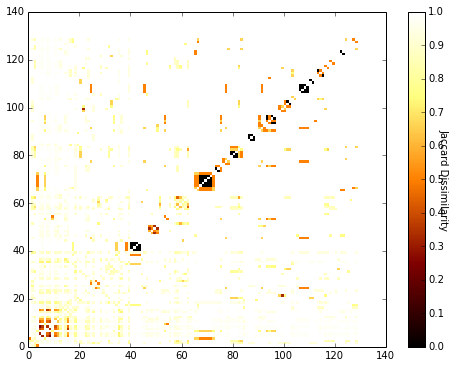

In [40]:
array = np.array(dissimilarity_matrix)

#create heatmap
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = ax.pcolor(array,cmap='afmhot')

#legend
cbar = plt.colorbar(heatmap)
cbar.set_label('Jaccard Dissimilarity', rotation=270)

In [15]:
af_dis = AffinityPropagation(affinity='precomputed')
af_dis.fit(dissimilarity_matrix)

AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

In [16]:
labels_dis = af_dis.labels_
labels_unique_dis = np.unique(labels_dis)
n_clusters_dis = len(labels_unique_dis)
print n_clusters_dis, 'Estimated clusters'

# print out results
for i in range(len(labels_unique_dis)):
    print 'Cluster %d - count:%d - ingredients:'%(i,len(labels_dis[labels_dis==i]))
    for index in np.where(labels_dis==i)[0]:
        print '   %s'%all_ingr_df['new_description'].unique()[index]

25 Estimated clusters
Cluster 0 - count:10 - ingredients:
   apples
   cottage cheese
   banana peppers
   lemon zest
   olives
   flour
   egg
   curry paste
   red wine vinegar
   fennel seed
Cluster 1 - count:2 - ingredients:
   garlic
   sweet potato
Cluster 2 - count:5 - ingredients:
   paprika
   apple sauce
   maple syrup
   kalamata olives
   bay leaf
Cluster 3 - count:7 - ingredients:
   hot sauce
   artichoke hearts
   cream cheese
   manzanilla olives
   onion powder
   chili powder
   cocounut oil
Cluster 4 - count:9 - ingredients:
   tahini
   black beans
   water
   basil
   portabello mushroom
   rosemary
   brown sugar
   cinnamon
   honey
Cluster 5 - count:6 - ingredients:
   green olives
   pumpkin
   white pepper
   sesame seed oil
   beets
   cabbage
Cluster 6 - count:2 - ingredients:
   balsamic vinegar
   oregano
Cluster 7 - count:7 - ingredients:
   sesame seeds
   cucumber
   zucchini
   sweet chili sauce
   thyme
   ground beef
   ranch
Cluster 8 - count:4 - in

In [17]:
#compose a compatible list of dissimilarity_cluster and add it to the dataframe
dissimilar_df = pd.DataFrame({'dissimilarity_cluster':labels_dis},index=all_ingr_df['new_description'].unique())

# Take a look at the data:
print len(dissimilar_df), 'entries'
print dissimilar_df.head(20)

merged_df = pd.concat([merged_df, dissimilar_df], axis=1)
merged_df.head(20)

129 entries
                dissimilarity_cluster
cheddar cheese                     17
hummus                             12
bread                              12
apples                              0
garbonzo beans                     20
olive oil                          16
peanut butter                      24
lemon juice                        19
garlic                              1
tofu                                9
salt                                9
cumin                              12
paprika                             2
green olives                        5
cayenne pepper                     22
tahini                              4
black beans                         4
pumpkin                             5
water                               4
curry powder                       19

[20 rows x 1 columns]


,mean_proportion,stddev_proportion,counts,norm_counts,count_cluster,similarity_cluster,dissimilarity_cluster
Italian dressing,0.100105,0.082766,4,0.048780,0,8,9
allspice,0.000554,0.000400,2,0.024390,0,24,20
apple sauce,0.089539,NaN,1,0.012195,0,5,2
apples,0.215378,0.170833,2,0.024390,0,10,0
artichoke hearts,0.256446,0.051010,3,0.036585,0,17,3
arugula,0.011392,NaN,1,0.012195,0,1,17
avocado,0.189037,0.039988,3,0.036585,0,18,10
bacon,0.049095,NaN,1,0.012195,0,5,11
baking soda,0.001161,NaN,1,0.012195,0,1,18
balsamic vinegar,0.026339,0.026988,3,0.036585,0,5,6


#Final Selection Based on Clustering for Count, Similarity and Dissimilarity

In [18]:
# print only ingredients for count_cluster!=0
selection1 = merged_df[['count_cluster','similarity_cluster','dissimilarity_cluster']]\
[merged_df['count_cluster']!=0].sort(['similarity_cluster','dissimilarity_cluster'])

print 'Selected:'
print selection1.head(len(selection1))

Selected:
                count_cluster  similarity_cluster  dissimilarity_cluster
onion                       1                   0                     16
garlic                      2                   1                      1
paprika                     1                   1                      2
basil                       1                   1                      4
tahini                      8                   1                      4
water                       5                   1                      4
parsley                     1                   1                      8
salt                        4                   1                      9
cumin                       7                   1                     12
olive oil                   3                   1                     16
black pepper                6                   1                     19
lemon juice                 3                   1                     19
garbonzo beans              2            

In [19]:
# now reject similarity_cluster!=1
selection2 = selection1[selection1['similarity_cluster']==1]
anti2 = selection1[selection1['similarity_cluster']!=1]

print 'Selected:'
print selection2
print ''
print 'Rejected:'
print anti2

Selected:
                count_cluster  similarity_cluster  dissimilarity_cluster
garlic                      2                   1                      1
paprika                     1                   1                      2
basil                       1                   1                      4
tahini                      8                   1                      4
water                       5                   1                      4
parsley                     1                   1                      8
salt                        4                   1                      9
cumin                       7                   1                     12
olive oil                   3                   1                     16
black pepper                6                   1                     19
lemon juice                 3                   1                     19
garbonzo beans              2                   1                     20

[12 rows x 3 columns]

Rejected:
       

In [20]:
# now consider only ingredients with shared dissimilarity_clusters
shared_clus = list()
unique_clus = list()
for dis_clus in selection2['dissimilarity_cluster'].unique():
    if len(selection2[selection2['dissimilarity_cluster']==dis_clus]) > 1:
        shared_clus.append(dis_clus)
    else:
        unique_clus.append(dis_clus)
    
selection3 = selection2.copy()
rejected = pd.DataFrame()
# drop any ingredient with a shared cluster AND count_cluster==1
for clus in shared_clus: #for each shared cluster
    #select all entries sharing this cluster:
    clus_df = selection3[selection3['dissimilarity_cluster']==clus]
    for i in range(len(clus_df)): #loop over these entries
        clus_df_row = clus_df.iloc[[i]] #select one shared entry at atime
        if clus_df_row['count_cluster'][0] == 1: #check if entries count_cluster==1
            rejected = pd.concat([rejected,clus_df.iloc[[i]]]) #add entry to a rejected list
            selection3.drop(clus_df_row.index[0],inplace=True) #drop corresponding entry from selection df
            
print 'Final Ingredient Selection:'
print selection3
print ''
print 'Rejected:'
print rejected

Final Ingredient Selection:
                count_cluster  similarity_cluster  dissimilarity_cluster
garlic                      2                   1                      1
paprika                     1                   1                      2
tahini                      8                   1                      4
water                       5                   1                      4
parsley                     1                   1                      8
salt                        4                   1                      9
cumin                       7                   1                     12
olive oil                   3                   1                     16
black pepper                6                   1                     19
lemon juice                 3                   1                     19
garbonzo beans              2                   1                     20

[11 rows x 3 columns]

Rejected:
       count_cluster  dissimilarity_cluster  similarity_cluste

#We Have a Final Ingredient Selection!
My choice of selection criteria seems reasonably motivated to me, and the final results judged qualitatively seem quite reasonable. Now all we have to do is write out the final selection to a database then calculate percentages for each ingredient.

#SUMMARY:

In [21]:
print '---------SELECTION PHASE 1-----------'
print 'Dropped all ingredients with count_cluster==0'
print 'Selected:'
print selection1
print '---------SELECTION PHASE 2-----------'
print 'Dropped ingredients with similarity_cluster!=1'
print 'Selected:'
print selection2
print ''
print 'Rejected:'
print anti2
print '-------FINAL SELECTION PHASE---------'
print 'Dropped ingredients with duplicate dis_clus AND count_cluster==1'
print 'Selected:'
print selection3
print ''
print 'Rejected:'
print rejected

---------SELECTION PHASE 1-----------
Dropped all ingredients with count_cluster==0
Selected:
                count_cluster  similarity_cluster  dissimilarity_cluster
onion                       1                   0                     16
garlic                      2                   1                      1
paprika                     1                   1                      2
basil                       1                   1                      4
tahini                      8                   1                      4
water                       5                   1                      4
parsley                     1                   1                      8
salt                        4                   1                      9
cumin                       7                   1                     12
olive oil                   3                   1                     16
black pepper                6                   1                     19
lemon juice                 3 

# Write Final Selection Results

In [28]:
# create a solitary colum of final_selection values
selection_df = selection3.copy()
selection_df['final_selection'] = 1
selection_df.drop(['count_cluster','similarity_cluster','dissimilarity_cluster'],axis=1,inplace=True)

# add column to full dataframe
final_df = merged_df.copy()
final_df = pd.concat([final_df,selection_df],axis=1)

#replace final_selection Nan's with 0
final_df['final_selection'].fillna(0,inplace=True)

#set the description index to be a normal column for pushing to db
final_df.reset_index(inplace=True)
final_df.rename(columns={'index': 'new_description'}, inplace=True)
final_df.head()

,new_description,mean_proportion,stddev_proportion,counts,norm_counts,count_cluster,similarity_cluster,dissimilarity_cluster,final_selection
0,Italian dressing,0.100105,0.082766,4,0.048780,0,8,9,0
1,allspice,0.000554,0.000400,2,0.024390,0,24,20,0
2,apple sauce,0.089539,NaN,1,0.012195,0,5,2,0
3,apples,0.215378,0.170833,2,0.024390,0,10,0,0
4,artichoke hearts,0.256446,0.051010,3,0.036585,0,17,3,0


In [31]:
#overwrite database with entries with our new columns
final_df.to_sql('base_ingredients', conn, if_exists='replace')

In [32]:
conn.close()